In [9]:
import numpy as np
import matplotlib.pyplot as plt
from emnist import extract_training_samples
from mdwsvm import mdwsvm
from mdwsvm_ad import mdwsvm_ad
from hybrid import hybrid

In [41]:
digits_images, digits_labels = extract_training_samples('digits')
letters_images, letters_labels = extract_training_samples('letters')

X_train = np.zeros((4000,28,28))
y_train = np.zeros((4000))
X_test = np.zeros((40000,28,28))
y_test = np.zeros((40000))

X_train[0:4000,:,:] = digits_images[0:4000,:,:] # 4000 digits training data
y_train[0:4000] = digits_labels[0:4000] # 4000 digits training label

X_test[0:40000,:,:] = letters_images[0:40000,:,:] 
X_test[0:2000,:,:] = digits_images[4000:6000,:,:]
y_test[0:40000] = letters_labels[0:40000] 
y_test[0:2000] = digits_labels[4000:6000]

[0. 0. 0. ... 0. 0. 0.]


In [42]:
print(y_test[1999])
print(y_train[3999])
print(digits_labels[3999])
print(digits_labels[5999])

10.0


IndexError: index 4000 is out of bounds for axis 0 with size 4000

<function matplotlib.pyplot.show(close=None, block=None)>

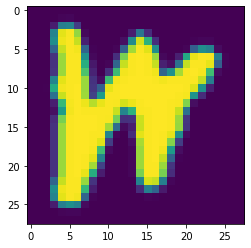

In [ ]:
plt.imshow(letters_images[0,:,:])
plt.show